In [0]:
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib as mpl
from zipfile import ZipFile
from matplotlib import style
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



In [4]:
mpl.rc('figure', figsize=(8, 7))
style.use('ggplot')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"eleveneleven","key":"39432b97f4cac489f6790f85dee7bf80"}'}

In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [0]:
!kaggle competitions download -c ieee-fraud-detection

In [12]:
zf = ZipFile('train_transaction.csv.zip', 'r')
zf.extractall()
zf.close()
zf = ZipFile('train_identity.csv.zip', 'r')
zf.extractall()
zf.close()

# Open DataFraes, and Merge
df_train_transaction = pd.read_csv('train_transaction.csv', low_memory=False)
df_train_identity = pd.read_csv('train_identity.csv', low_memory=False)
df_train = pd.merge(df_train_transaction, df_train_identity, 
  on='TransactionID',
how='left')
df_train.shape

(590540, 434)

**One of the first things I decided to do, was check how imbalanced this dataset is, considering that Fraud Detection datasets are known to have a high amount of imbalance between isFraud=0 and isFraud=1.**

In [13]:
df_isfraud = df_train[df_train.isFraud==1]
imbalance_percentage = len(df_isfraud)/len(df_train)

print('df_train: '+ str(df_train.shape))
print('df_isfraud: '+ str(df_isfraud.shape))
print('class imbalance percentage: ' + str(round(imbalance_percentage, 5)))

df_train: (590540, 434)
df_isfraud: (20663, 434)
class imbalance percentage: 0.03499


**Wow! Only 3% of the rows of this dataframe are identified as isFraud=1, the other 97% are isFraud=0. Very imbalanced! Be careful to acknowledge that predictions can be dramatically biased based on this fact.**

In [14]:
# Feature Selection based on the percentage of NA's in a columns
df_na = pd.DataFrame({"na_count":df_train.isnull().sum().sort_values(ascending=False)})
df_na["percentage"]=df_na["na_count"]/len(df_train)
limit=0.15 
selected_features = df_na[df_na["percentage"]<limit].index 
df = df_train[df_train.columns.intersection(selected_features)]

# Handling our Categorical Variables
# Determine which categorical variables should remain, and what they are.
list_categorical_columns = []
list_categorical_columns_remaining = df[df.select_dtypes(include=['object']).columns].columns.tolist()
print('Remaining Categorical Columns: ' + ', '.join(list_categorical_columns_remaining))

# Create dummy variable dataframes to encode categorical variables into numbers
for categorical_column_name in list_categorical_columns_remaining:
    list_categorical_columns.append(categorical_column_name)

# Concatenate our dummy dataframes into our primary dataframe, 
# then get rid of the non-encoded variables
df_dummies = pd.get_dummies(df[list_categorical_columns])
df = pd.concat([df, df_dummies], axis=1)
df = df._get_numeric_data()

Remaining Categorical Columns: ProductCD, card4, card6


Out of all of the original 434 columns, only 0.0276 columns are composed of fewer than 80% NaN Values.
Below, we can see a Bar Plot showcasing the percentage of variables which are the most-highly populated by NaN values.


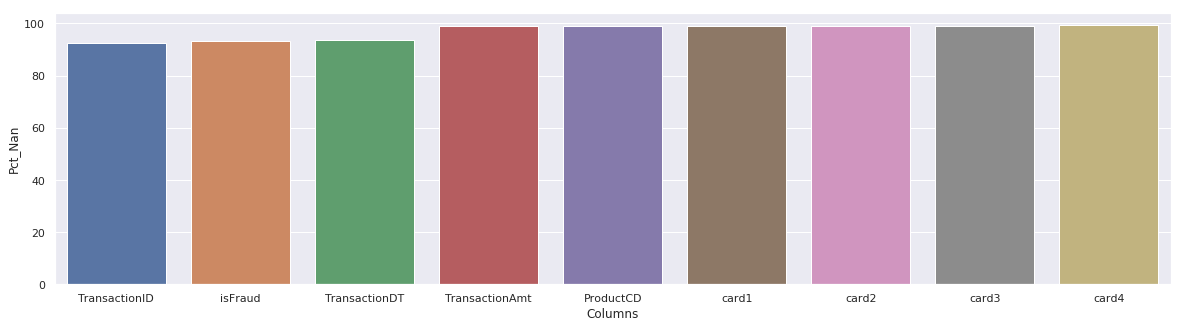

In [15]:

series_nanvalues = pd.isnull(df_train).sum().sort_values(ascending=False)
percentage_nanvalues = (series_nanvalues/len(df_train))*100
df_na = pd.concat(objs = [series_nanvalues, percentage_nanvalues], keys=['Columns','Pct_Nan'], axis=1)
df_na_90 = df_na[df_na.Pct_Nan >= 90]
df_na_80 = df_na[df_na.Pct_Nan >= 80]
percentage_nans_under_80 = str(round(len(df_na_90)/len(df_na),4))

print('Out of all of the original 434 columns, only ' + percentage_nans_under_80 + ' columns are composed of fewer than 80% NaN Values.')
print('Below, we can see a Bar Plot showcasing the percentage of variables which are the most-highly populated by NaN values.')
sns.set(style="darkgrid", font_scale=1)
plt.figure(figsize=(20,5))
p = sns.barplot(x = 'Columns', y='Pct_Nan', data=df_na_90)
p.set_xticklabels(list(df_train.columns))
p

In [17]:
# training our model
df2 = df.copy()
df2.fillna(value=df2.median(), inplace=True)
X = np.array(df2.drop(['isFraud'], axis=1))
X = preprocessing.scale(X)
y = np.array(df2['isFraud'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

classifier_logistic = LogisticRegression(solver='lbfgs')
classifier_logistic.fit(X_train, y_train)
confidence_logistic = round(classifier_logistic.score(X_test, y_test),6)
print('\tLogistic Confidence: ' + str(confidence_logistic) + '\n')

	Logistic Confidence: 0.967792



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
